# 2D trajectories of trees

## 1 Setup

First, setup the database

In [1]:
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Then import all we need for the analysis

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import numpy as np
from pandas import DataFrame
import seaborn as sb
from sklearn.manifold import MDS

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

Equip our models with useful tools

In [3]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

### 1.1 Trajectory plotting function

Define our trajectory plotting function

In [4]:
def plot_trajectories(x, y, **kwargs):
    data = kwargs.pop('data')
    x_name = y_name = ''
    if isinstance(x, str):
        x_name = x
        x = data[x_name].iloc
    if isinstance(y, str):
        y_name = y
        y = data[y_name].iloc
    ax = kwargs.get('ax', plt.gca())
    
    # Get indices
    indices = {}
    for i, sentence_id in enumerate(data['sentence id']):
        indices[sentence_id] = i
    # Check each sentence appears only once
    assert len(indices) == len(data['sentence id'])
    
    # Get sentences and leaves
    sentences = [Sentence.objects.get(id=id) for id in data['sentence id']]
    assert len(set(s.tree for s in sentences)) == 1
    tree = sentences[0].tree
    root = tree.root
    size = len(sentences)
    leaves = set([s for s in sentences if s.children.kept.count() == 0])
    
    # Define colors
    heads_indices = {}
    heads = root.children.kept.all()
    for i, head in enumerate(heads):
        heads_indices[head.id] = i
    cmap, palette = mpl_palette(len(heads_indices))
    
    # Plot sentences
    leaves_indices = [indices[leaf.id] for leaf in leaves]
    colors = np.array([(.5, .5, .5, 1)] * size)
    colors[indices[root.id]] = (1, 0, 0, 1)
    if len(leaves) > 0:
        colors[leaves_indices] = [palette[heads_indices[leaf.head.id]] for leaf in leaves]
    sizes = np.ones(size) * 50
    sizes[indices[root.id]] = 200
    if len(leaves) > 0:
        sizes[leaves_indices] = 200
    ax.scatter(x[:], y[:], c=colors, s=sizes, edgecolors=(0, 0, 0, 0))
    
    # Plot links
    links = [[s, child]
             for s in sentences
             for child in s.children.kept.all()
             if child in sentences]
    segments = [[[x[indices[s.id]], y[indices[s.id]]],
                 [x[indices[child.id]], y[indices[child.id]]]]
                for (s, child) in links]
    colors = np.array([heads_indices[child.head.id] for (_, child) in links])
    lc = LineCollection(segments,
                        zorder=1, cmap=cmap,
                        norm=plt.Normalize(0, colors.max()))
    lc.set_array(colors)
    lc.set_linewidths(1.5 * np.ones(len(segments)))
    ax.add_collection(lc)
    
    # Set legend data (seaborn catches legend stuff if we do it here,
    # so we return some data by this mechanism and use it in the
    # plotting code after FacetGrid.map_dataframe()).
    legends = kwargs.get('legends', None)
    if legends is not None:
        legend_handles = []
        for i, head in enumerate(heads):
            legend_handles.append(Patch(color=palette[heads_indices[head.id]],
                                        label='#{}'.format(head.id)))
        legends[tree.id] = legend_handles
    
    # Set chrome
    if kwargs.get('set_chrome', False):
        ax.set_title('tree id = {}'.format(tree.id))
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)

## 2 Trajectories in MDS

Add the multi-dimensional scaling tools

In [5]:
@memoized
def similarities(self, distance_type, with_dropped):
    if distance_type not in Sentence.DISTANCE_TYPES:
        raise ValueError(("Unkown distance type "
                          "(not one of {}): {}").format(distance_type, Sentence.DISTANCE_TYPES))
    distance_name = distance_type + '_distance'

    # Compute similarities matrix
    sentences = self.sentences.with_dropped(with_dropped).all()
    size = len(sentences)
    similarities = np.zeros((size, size))
    indices = {}
    for i, s1 in enumerate(sentences):
        if s1.id not in indices:
            indices[s1.id] = i
        for j, s2 in enumerate(sentences):
            similarities[i, j] = getattr(s1, distance_name)(s2)
    
    # Check we saw all the indices go past
    assert len(indices) == size
    
    return (similarities, indices)

@memoized
def scaling(self, distance_type, with_dropped, is_metric, init=None):
    # Compute similarities
    similarities, indices = self.similarities(distance_type, with_dropped)
    
    # Compute scaling
    if init is None:
        mds = MDS(n_components=2, metric=is_metric, max_iter=3000,
                  dissimilarity='precomputed', n_jobs=-2)
        pos = mds.fit_transform(similarities)
    else:
        mds = MDS(n_components=2, metric=is_metric, max_iter=3000,
                  dissimilarity='precomputed', n_jobs=-2, n_init=1)
        pos = mds.fit_transform(similarities, init=init)
    
    data = DataFrame([{'sentence id': sentence_id,
                       'x': pos[indices[sentence_id], 0],
                       'y': pos[indices[sentence_id], 1]}
                      for sentence_id in indices.keys()])
    
    return data, mds.stress_

Tree.similarities = similarities
Tree.scaling = scaling

First check that unspamming and unroguing the trees reduces the final stress of our downscalings.

In [6]:
trees = Tree.objects.experiment.all()
stresses_drop = np.zeros_like(trees)
stresses = np.zeros_like(trees)
print
print('Computing...', end='')
for i, tree in enumerate(trees):
    print(' #{}'.format(tree.id), end='')
    stresses_drop[i] = tree.scaling('ordered_content', True, True)[1]
    stresses[i] = tree.scaling('ordered_content', False, True)[1]

Computing... #1 #2 #3 #4 #5 #6 #7 #8 #9 #10 #11 #12 #13 #14 #15 #16 #17 #18 #20 #22 #23 #25 #26 #27 #28 #29 #30 #31 #32 #33 #34 #36 #37 #38 #39 #40 #41 #42 #43 #44 #45 #46 #47 #48 #49 #50 #51 #52 #53 #54

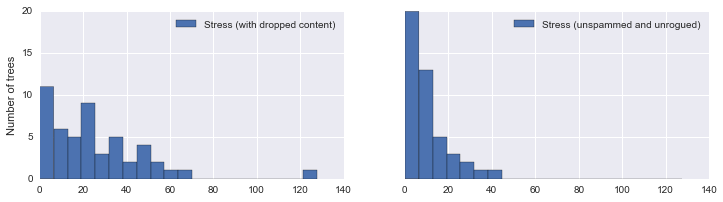

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)
bins = axes[0].hist(stresses_drop, 20, label='Stress (with dropped content)')[1]
axes[0].set_ylabel('Number of trees')
axes[0].legend(loc='best')
axes[1].hist(stresses, bins=bins, label='Stress (unspammed and unrogued)')
axes[1].legend(loc='best');

Yay, that's a nice improvement!

Now plot the tree trajectories

Computing... #11 #53 #6 #8 #13 #34 #1 #2 #7 #10 #27 #31 #33 #5 #12 #16 #18 #23 #29 #30 #41 #25 #28 #43 #3 #32 #4 #9 #36 #15 #22 #26 #50 #14 #38 #17 #54 #20 #40 #44 #39 #45 #48 #37 #42 #51 #47 #52 #46 #49

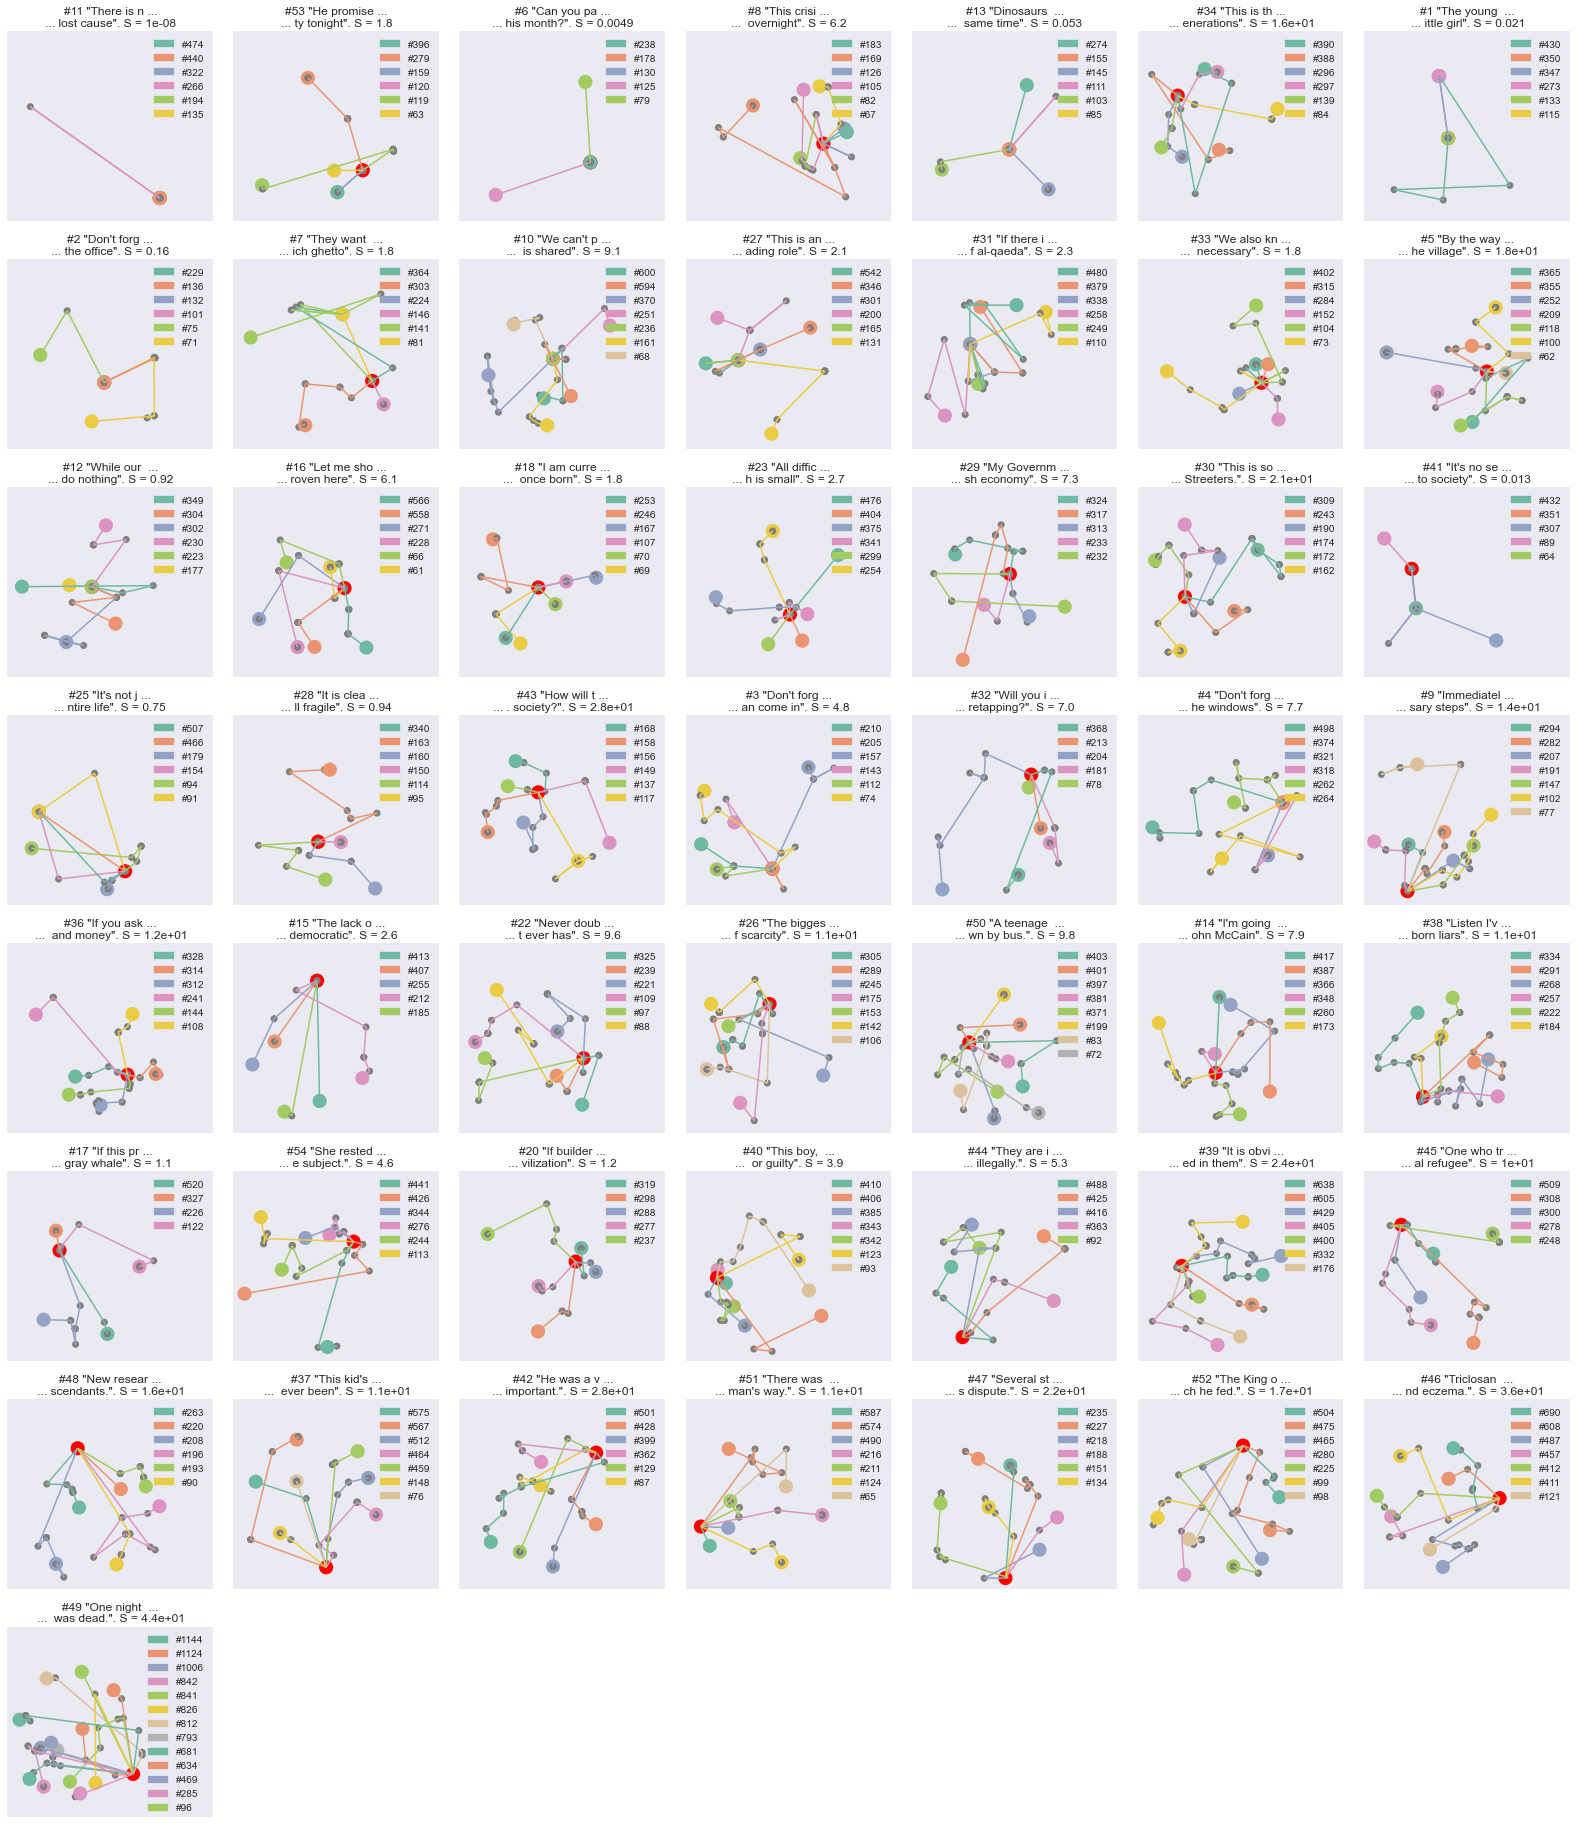

In [8]:
# Parameters
trees = Tree.objects.experiment.all()
n_cols = 7

# Ordering
trees = sorted(trees, key=lambda tree: (len(tree.root.content_words), tree.id))

# Plot
n_rows = int(np.ceil(len(trees) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
print('Computing...', end='')
for i, trees_line in enumerate(grouper(trees, n_cols)):
    for j, tree in enumerate(trees_line):
        if tree is None:
            break
        
        print(' #{}'.format(tree.id), end='')

        text = tree.root.text
        if len(text) > 25:
            text = text[:10] + ' ...\n... ' + text[-10:]
        data, stress = tree.scaling('ordered_content', False, True)
        legend = {}
        ax = axes.flat[i * n_cols + j]
        plot_trajectories(data['x'], data['y'], data=data, ax=ax, legends=legend)
        ax.set_title('#{} "{}". S = {:.2}'.format(tree.id, text, stress))
        ax.set_xticks([])
        ax.set_yticks([])
        xlim = ax.get_xlim()
        ax.set_xlim((xlim[0], xlim[1] * 1.5))
        ylim = ax.get_ylim()
        ax.set_ylim((ylim[0], ylim[1] * 1.3))
        ax.legend(handles=legend[tree.id], loc='upper right')

for k in range(i * n_cols + j, n_cols * n_rows):
    axes.flat[k].set_axis_off()
fig.subplots_adjust(wspace=.1, hspace=.2)
fig.savefig('/home/sl/Downloads/gistr/trajectories_mds.png', dpi=300)

## 3 Trajectories in length ~ difference from root

First generate our data (we'll use the same in all further plots)

In [9]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    order.append({'tree id': tree.id,
                  'root_content_words_count': len(root.content_words)})
    for sentence in tree.sentences.kept.all():
        length = len(sentence.content_words)
        rate = np.array([sentence.ordered_content_distance(child, normalized=False) / length
                         for child in sentence.children.kept.all()]).mean()
        data.append({'tree id': tree.id,
                     'sentence id': sentence.id,
                     'length': length,
                     'length / len(root)': length / len(root.content_words),
                     'diff from root': \
                         root.unordered_content_distance(sentence),
                     'distance to root': \
                         root.ordered_content_distance(sentence, normalized=False) / \
                             len(root.content_words),
                     'depth': sentence.depth,
                     'change rate': rate
                    })
data = DataFrame(data)
root_order = DataFrame(order).sort_values(['root_content_words_count', 'tree id'])

/home/sl/.virtualenvs/spreadr/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)

  warnings.warn("Mean of empty slice.", RuntimeWarning)



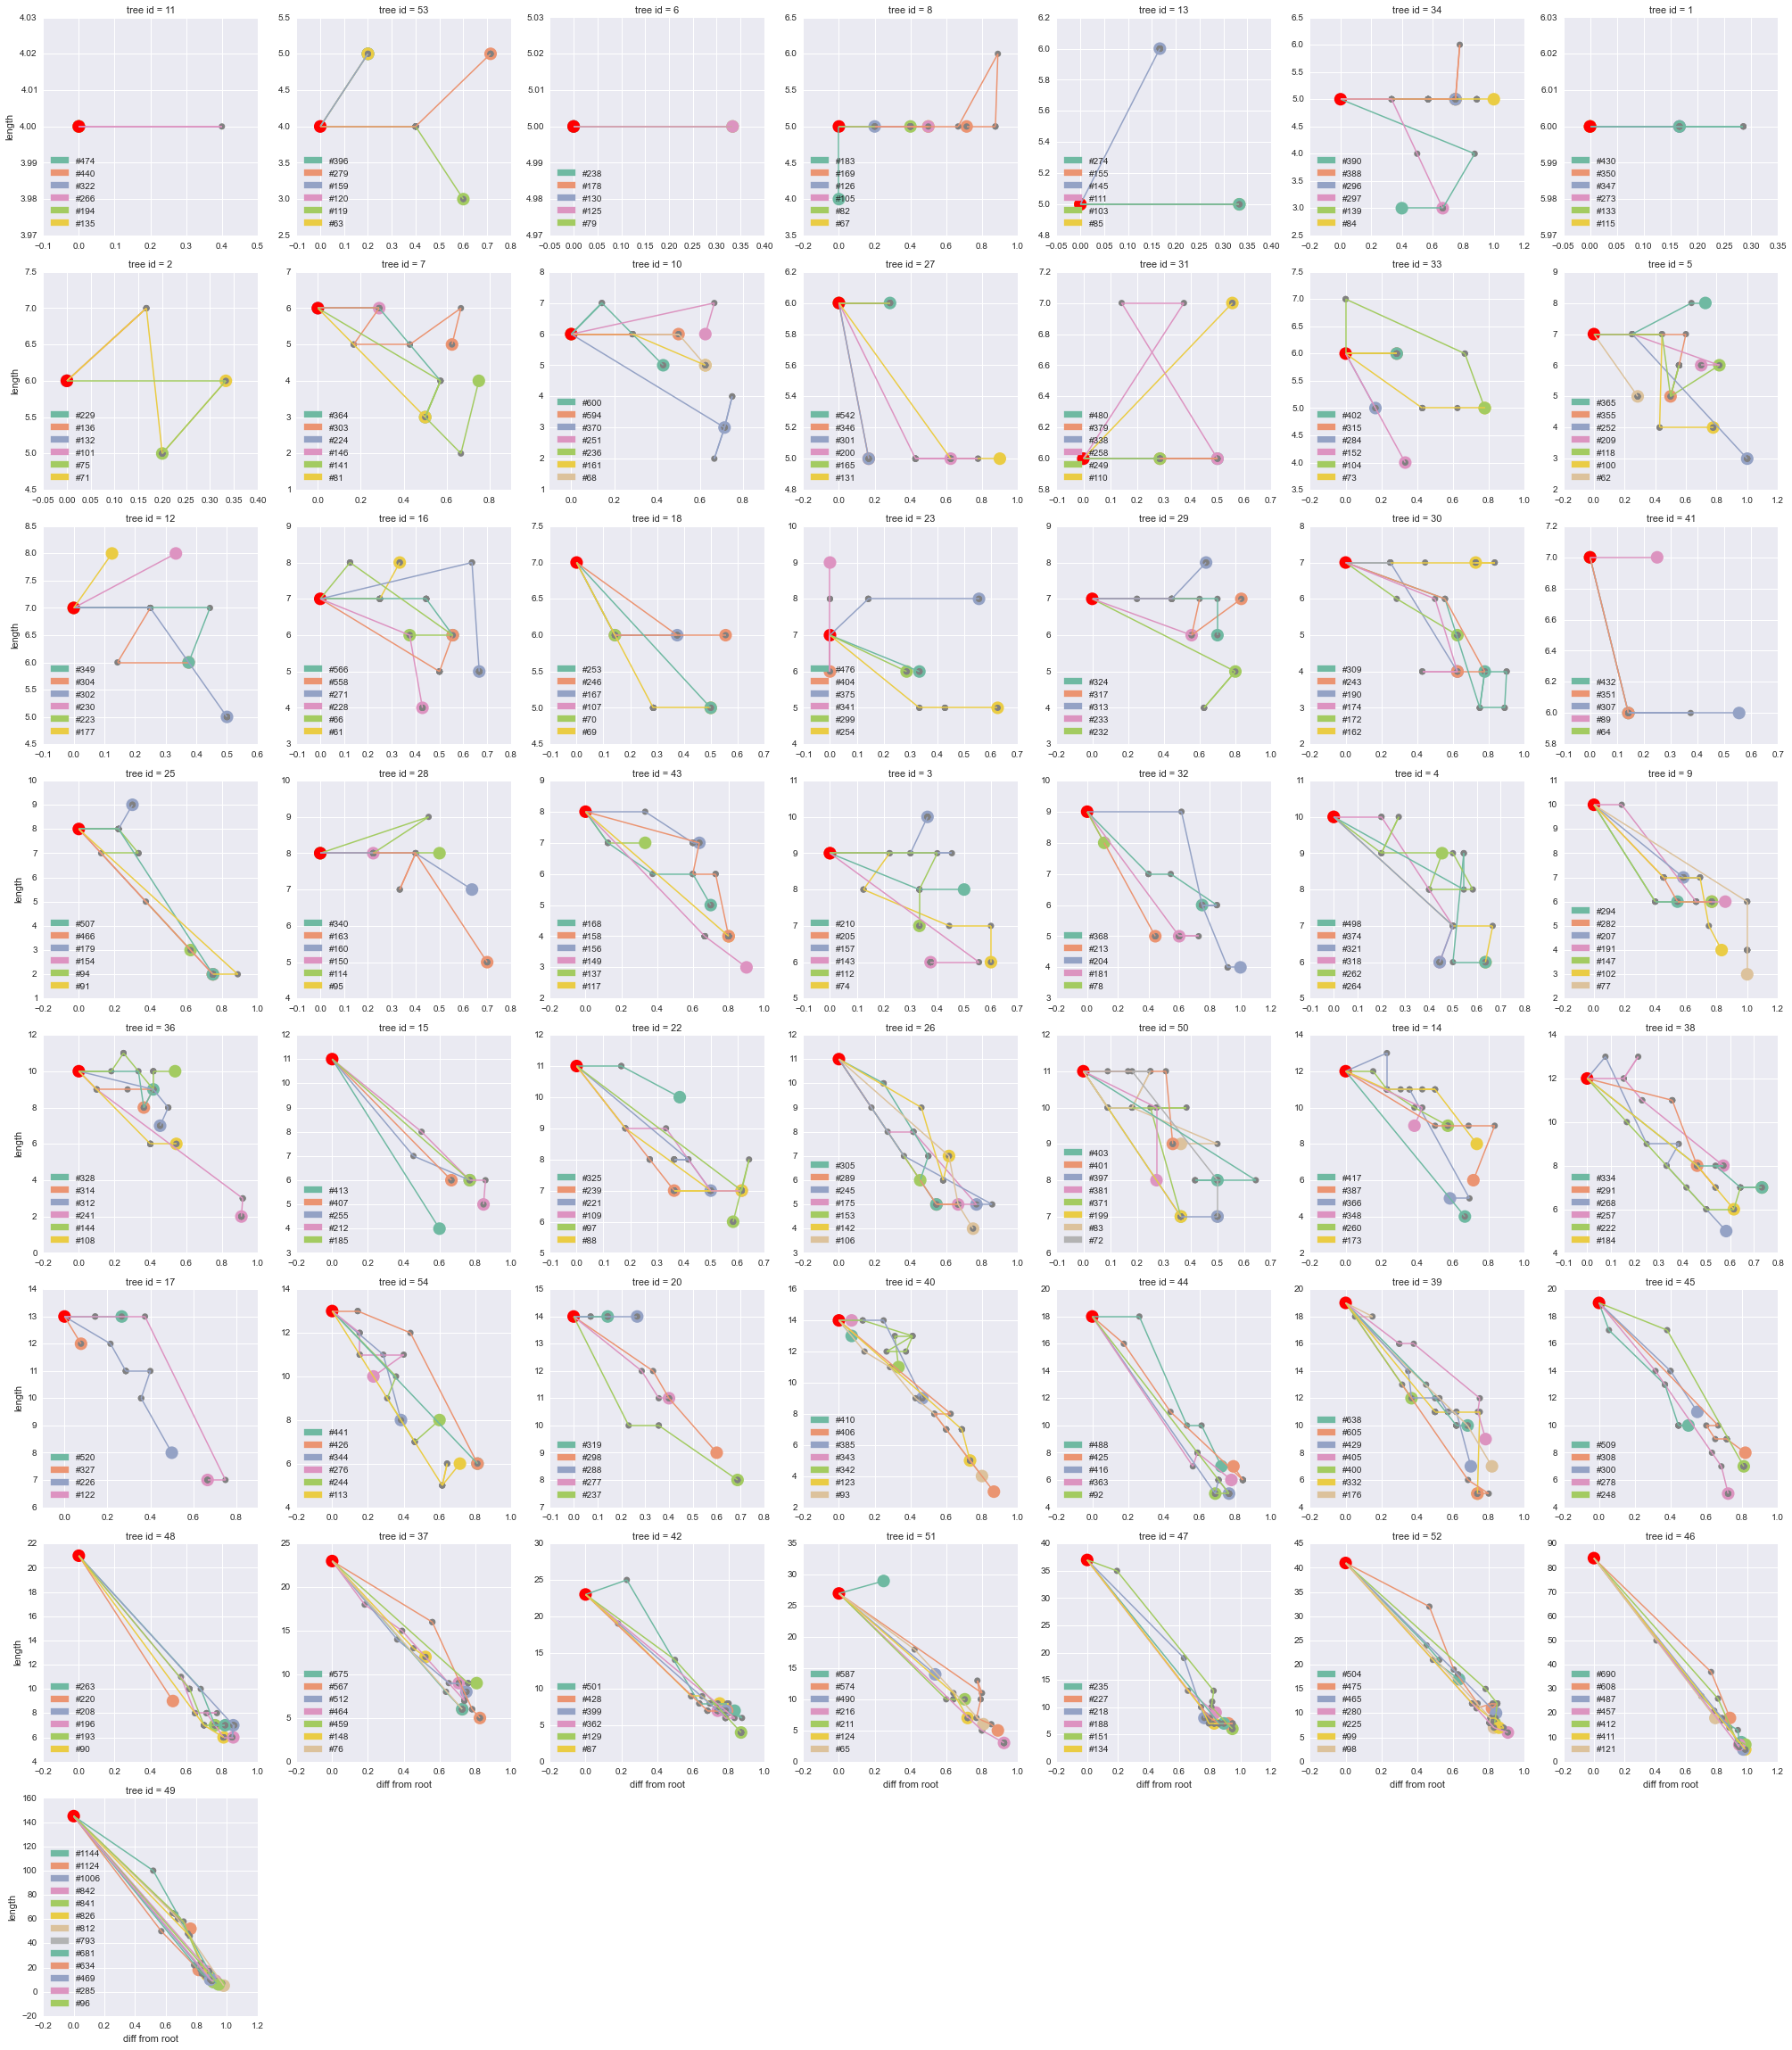

In [10]:
legends = {}
g = sb.FacetGrid(data, col='tree id', dropna=False,
                 sharex=False, sharey=False,
                 col_wrap=7, size=4, col_order=root_order['tree id'])
g.map_dataframe(plot_trajectories, 'diff from root', 'length',
                set_chrome=True, legends=legends);
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[root_order['tree id'].iloc[i]], loc='lower left')
g.savefig('/home/sl/Downloads/gistr/trajectories_length-diffroot.png', dpi=300)

## 4 Trajectories in difference from root ~ depth

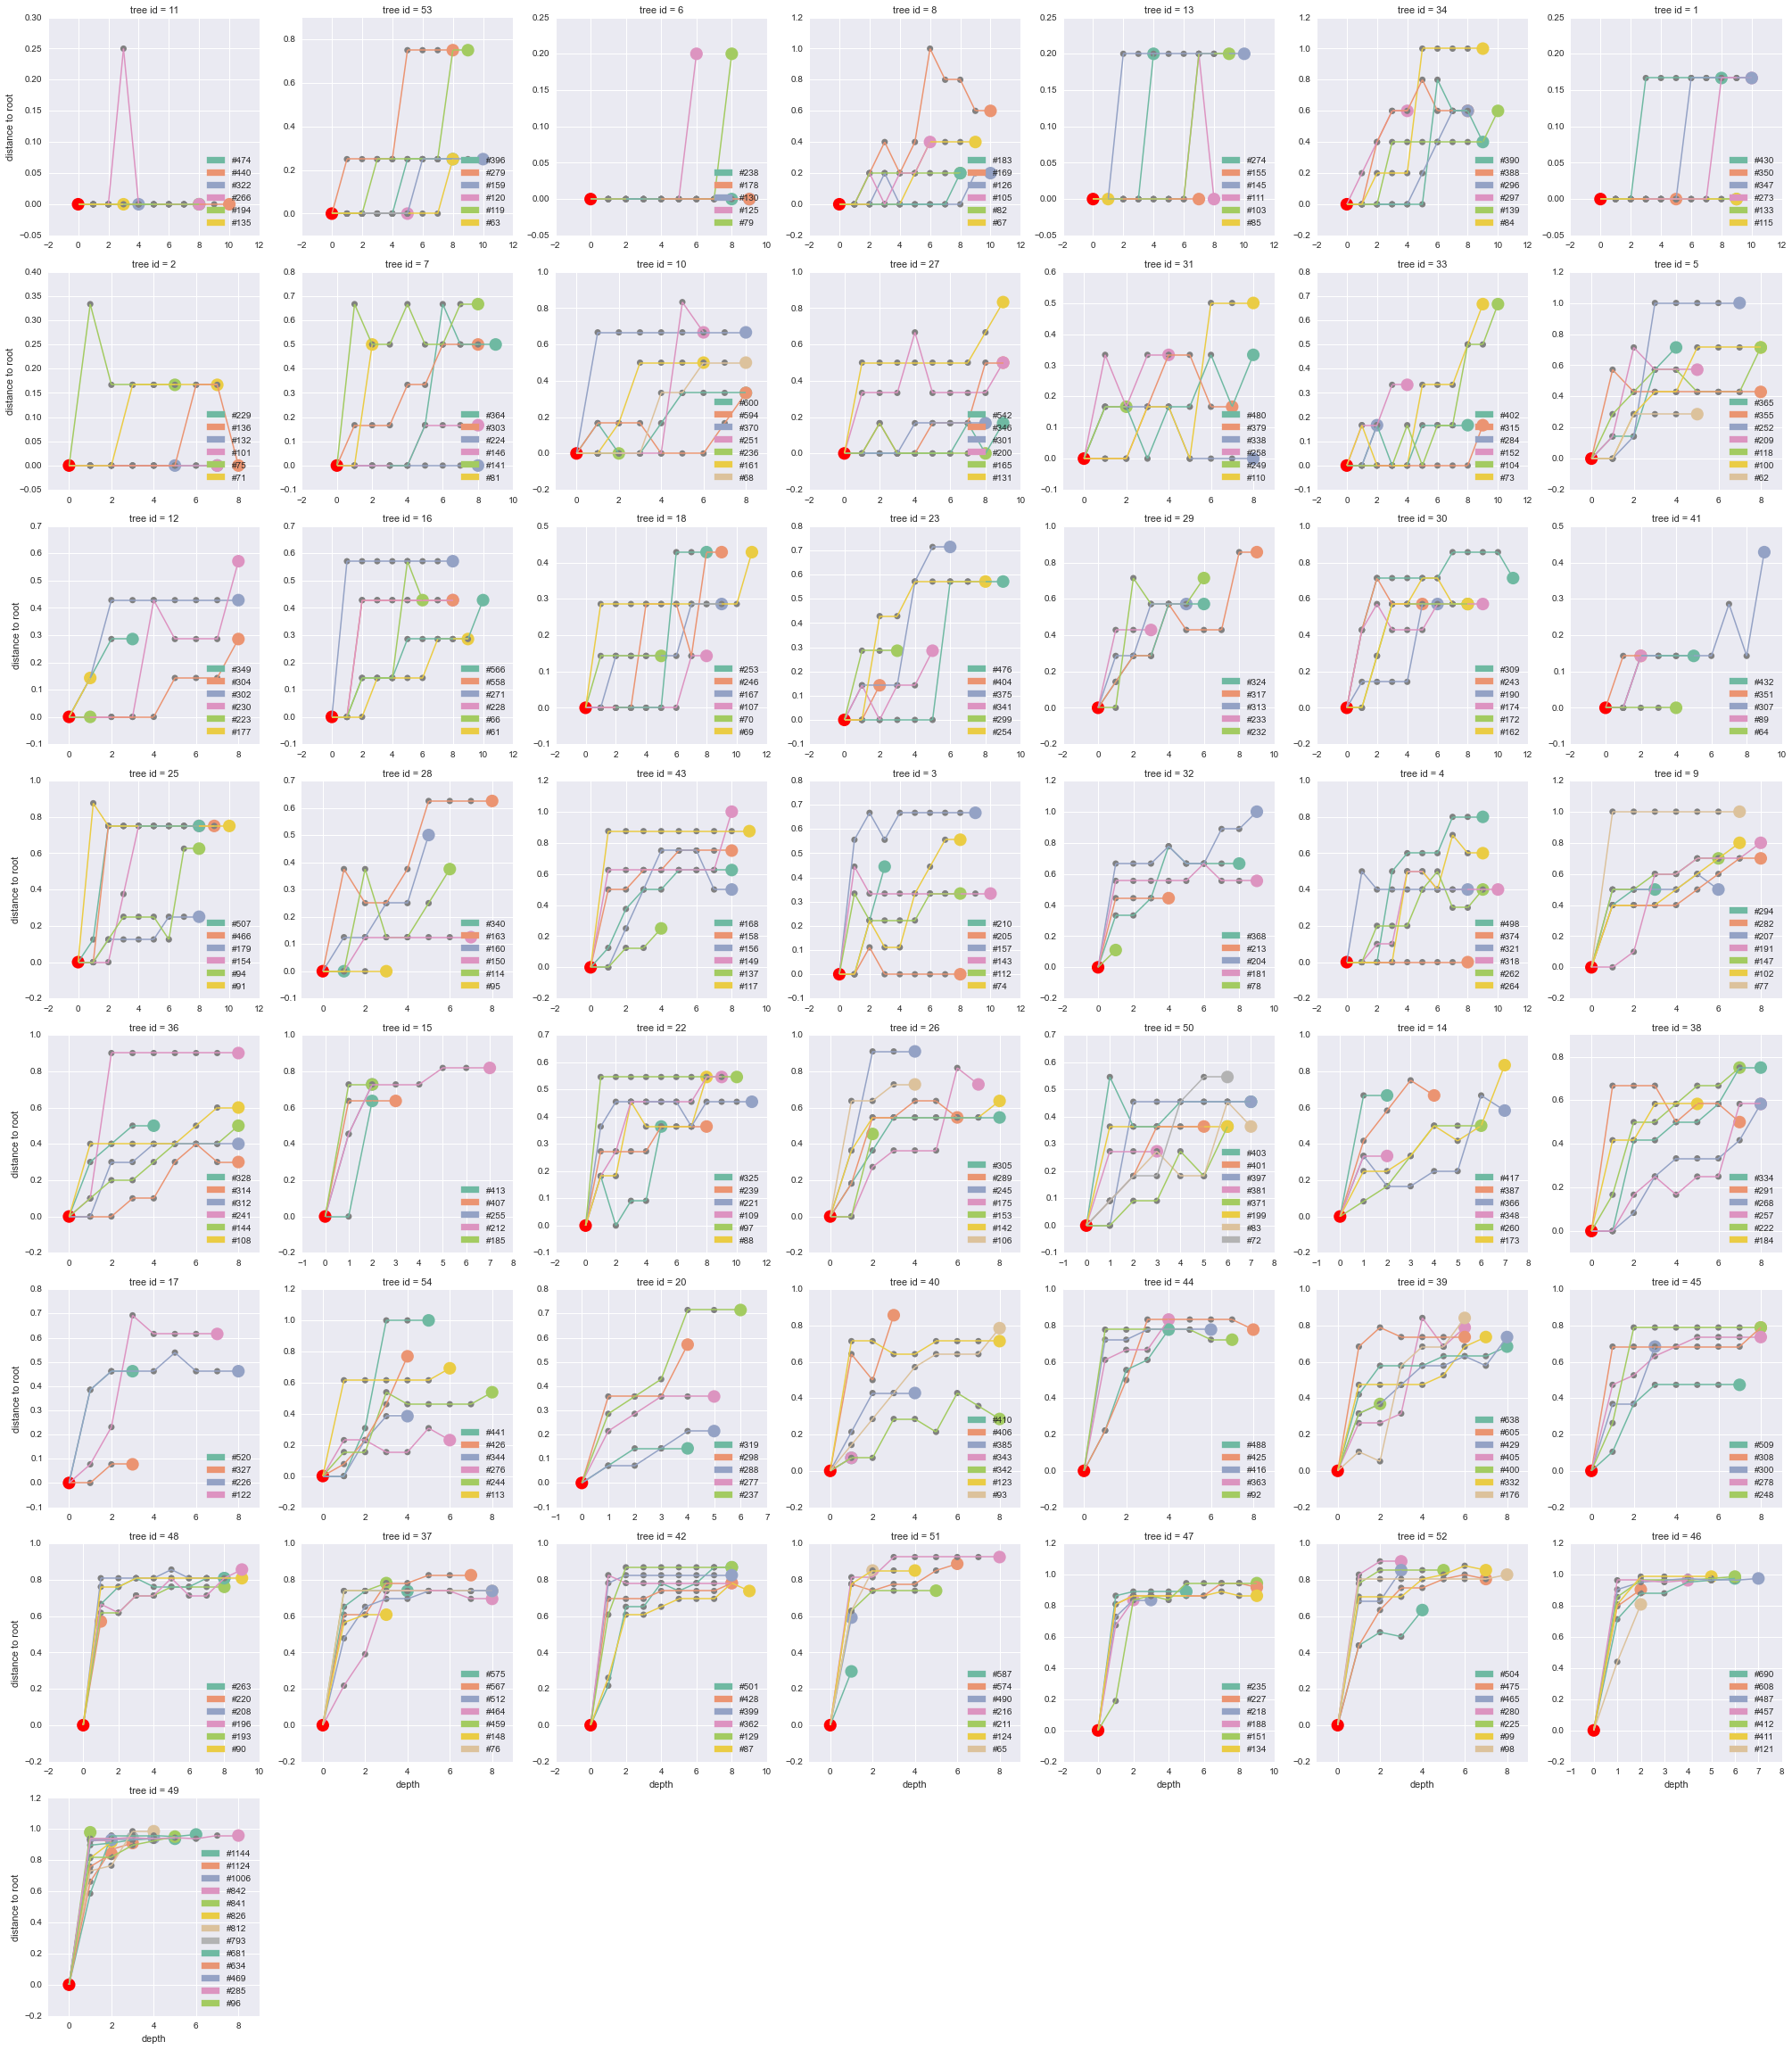

In [11]:
legends = {}
g = sb.FacetGrid(data, col='tree id', dropna=False,
                 sharex=False, sharey=False,
                 col_wrap=7, size=4, col_order=root_order['tree id'])
g.map_dataframe(plot_trajectories, 'depth', 'distance to root',
                set_chrome=True, legends=legends)
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[root_order['tree id'].iloc[i]], loc='lower right')
g.savefig('/home/sl/Downloads/gistr/trajectories_distance-to-root_depth.png', dpi=300)

## 5 Trajectories in change rate ~ depth

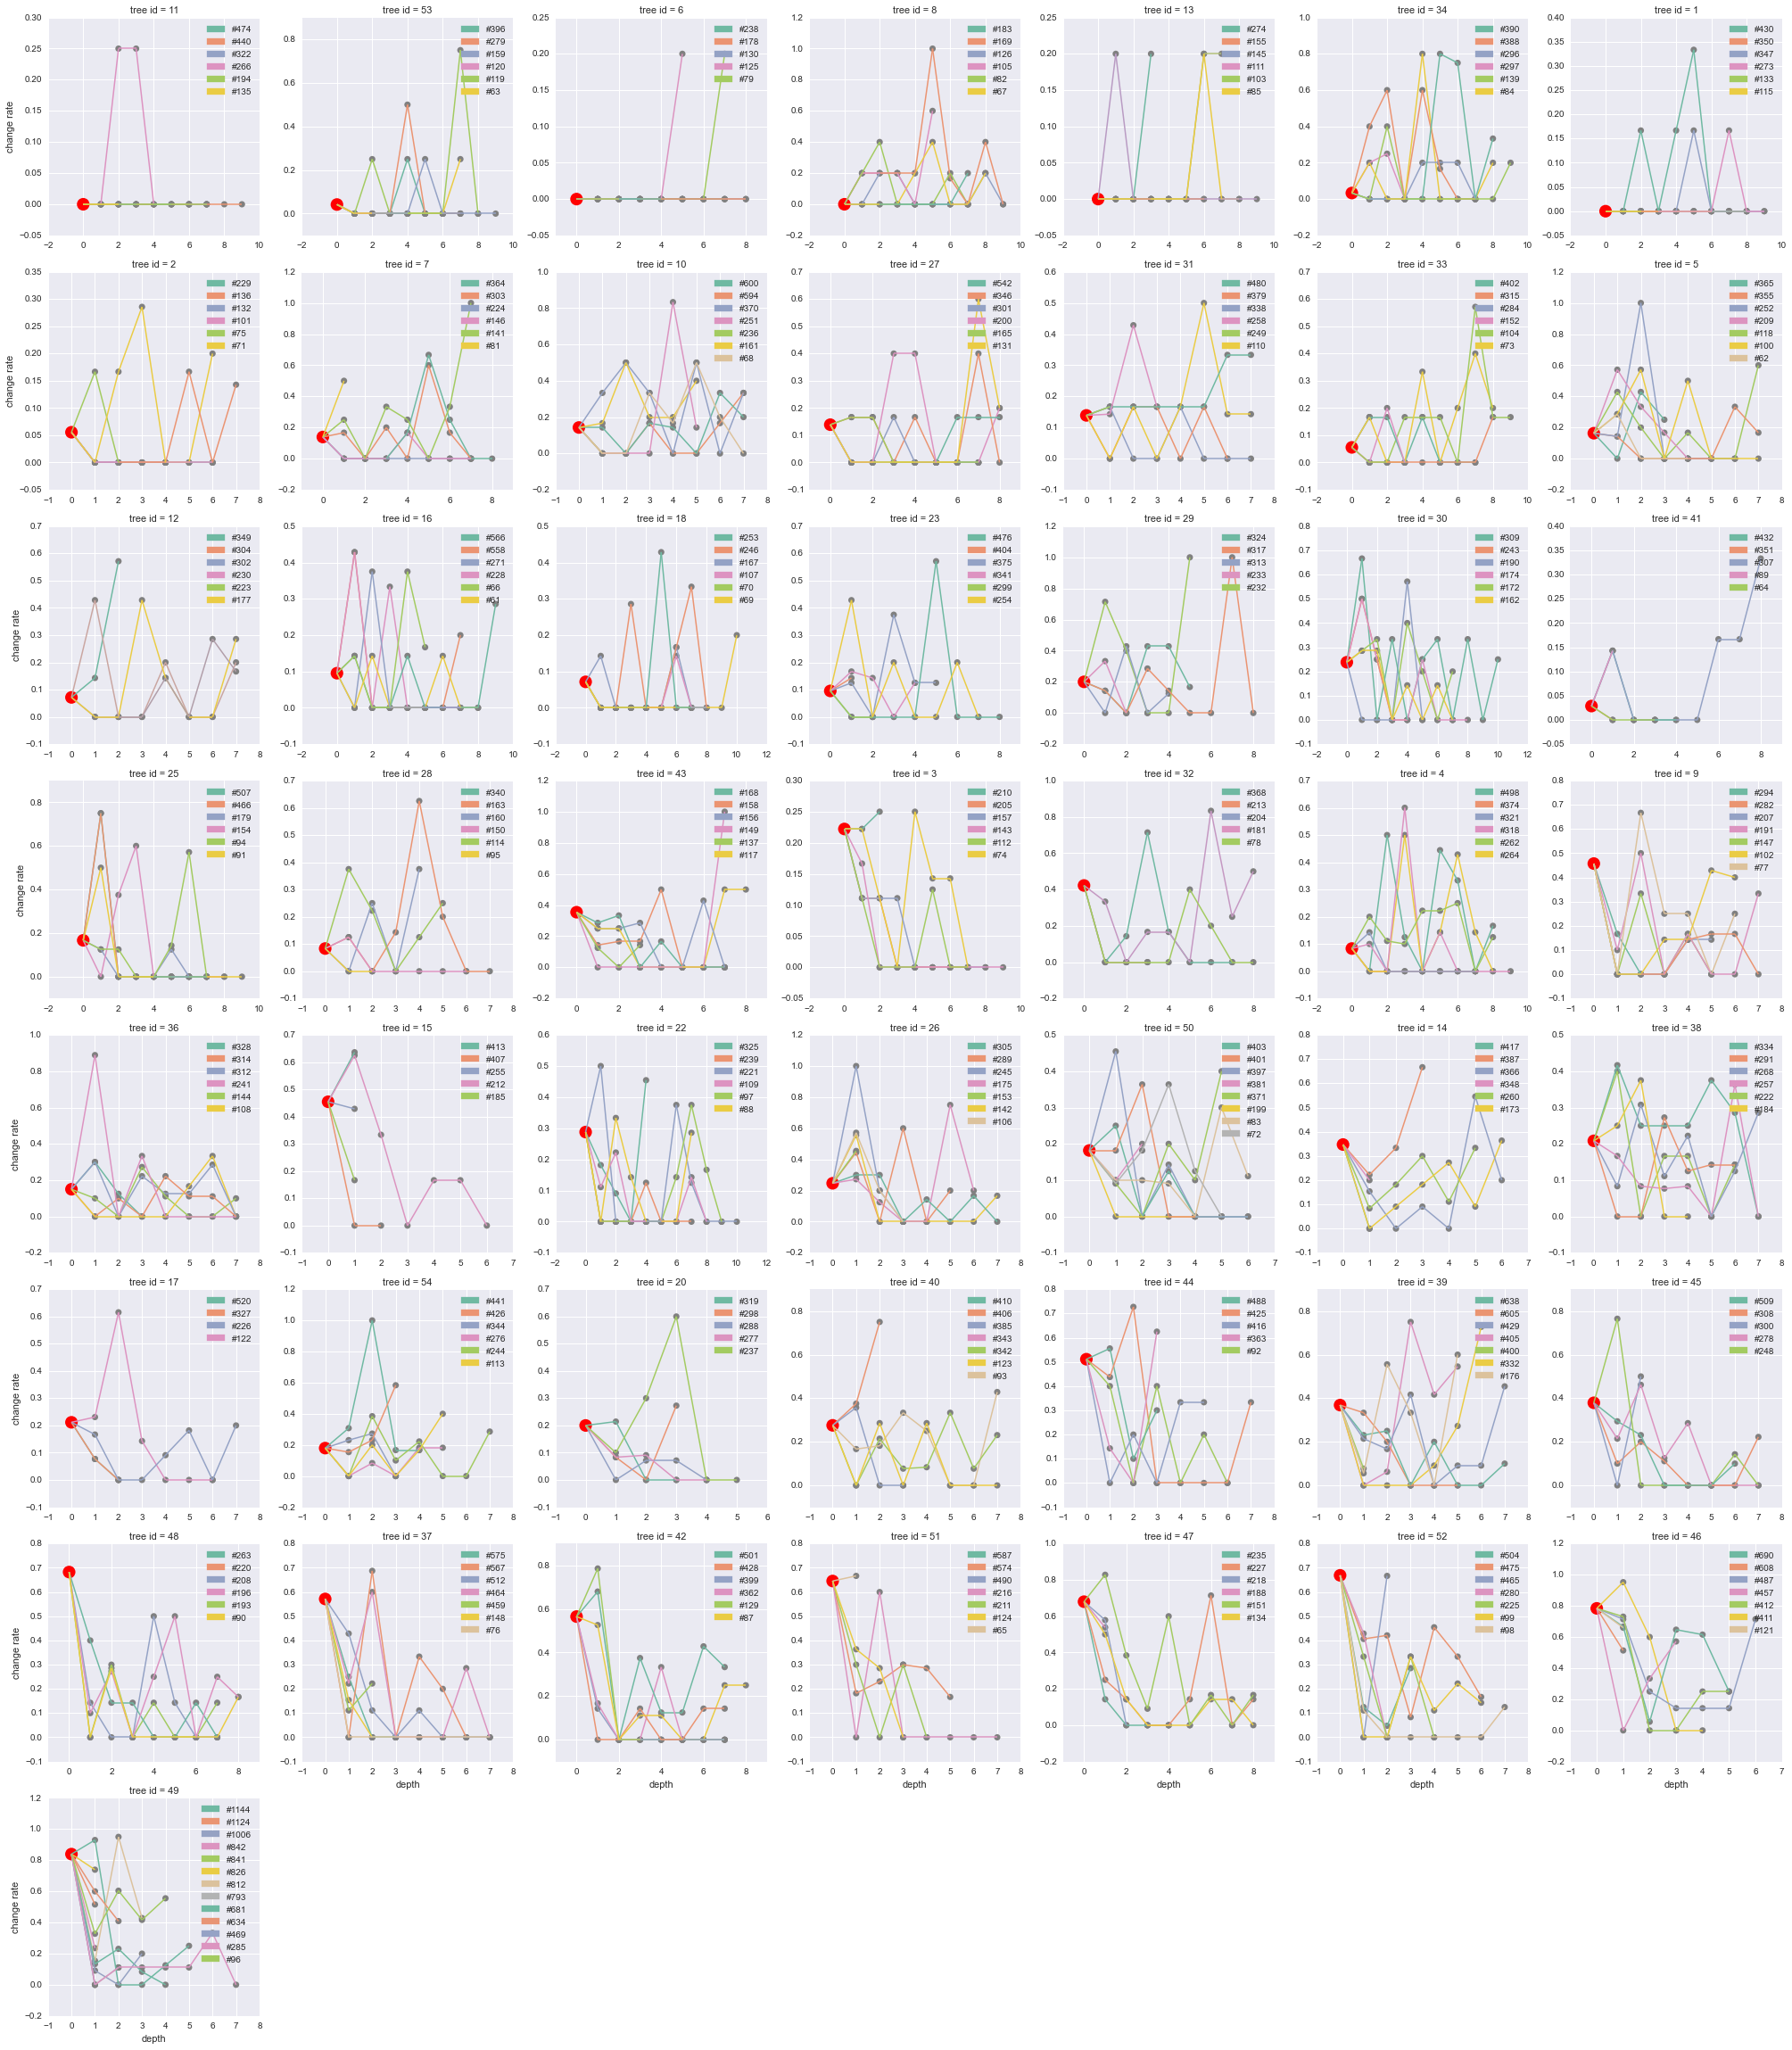

In [12]:
legends = {}
g = sb.FacetGrid(data, col='tree id',
                 sharex=False, sharey=False,
                 col_wrap=7, size=4, col_order=root_order['tree id'])
g.map_dataframe(plot_trajectories, 'depth', 'change rate',
                set_chrome=True, legends=legends)
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[root_order['tree id'].iloc[i]], loc='upper right')
g.savefig('/home/sl/Downloads/gistr/trajectories_changerate-depth.png', dpi=300)

## 6 Trajectories in length ~ depth

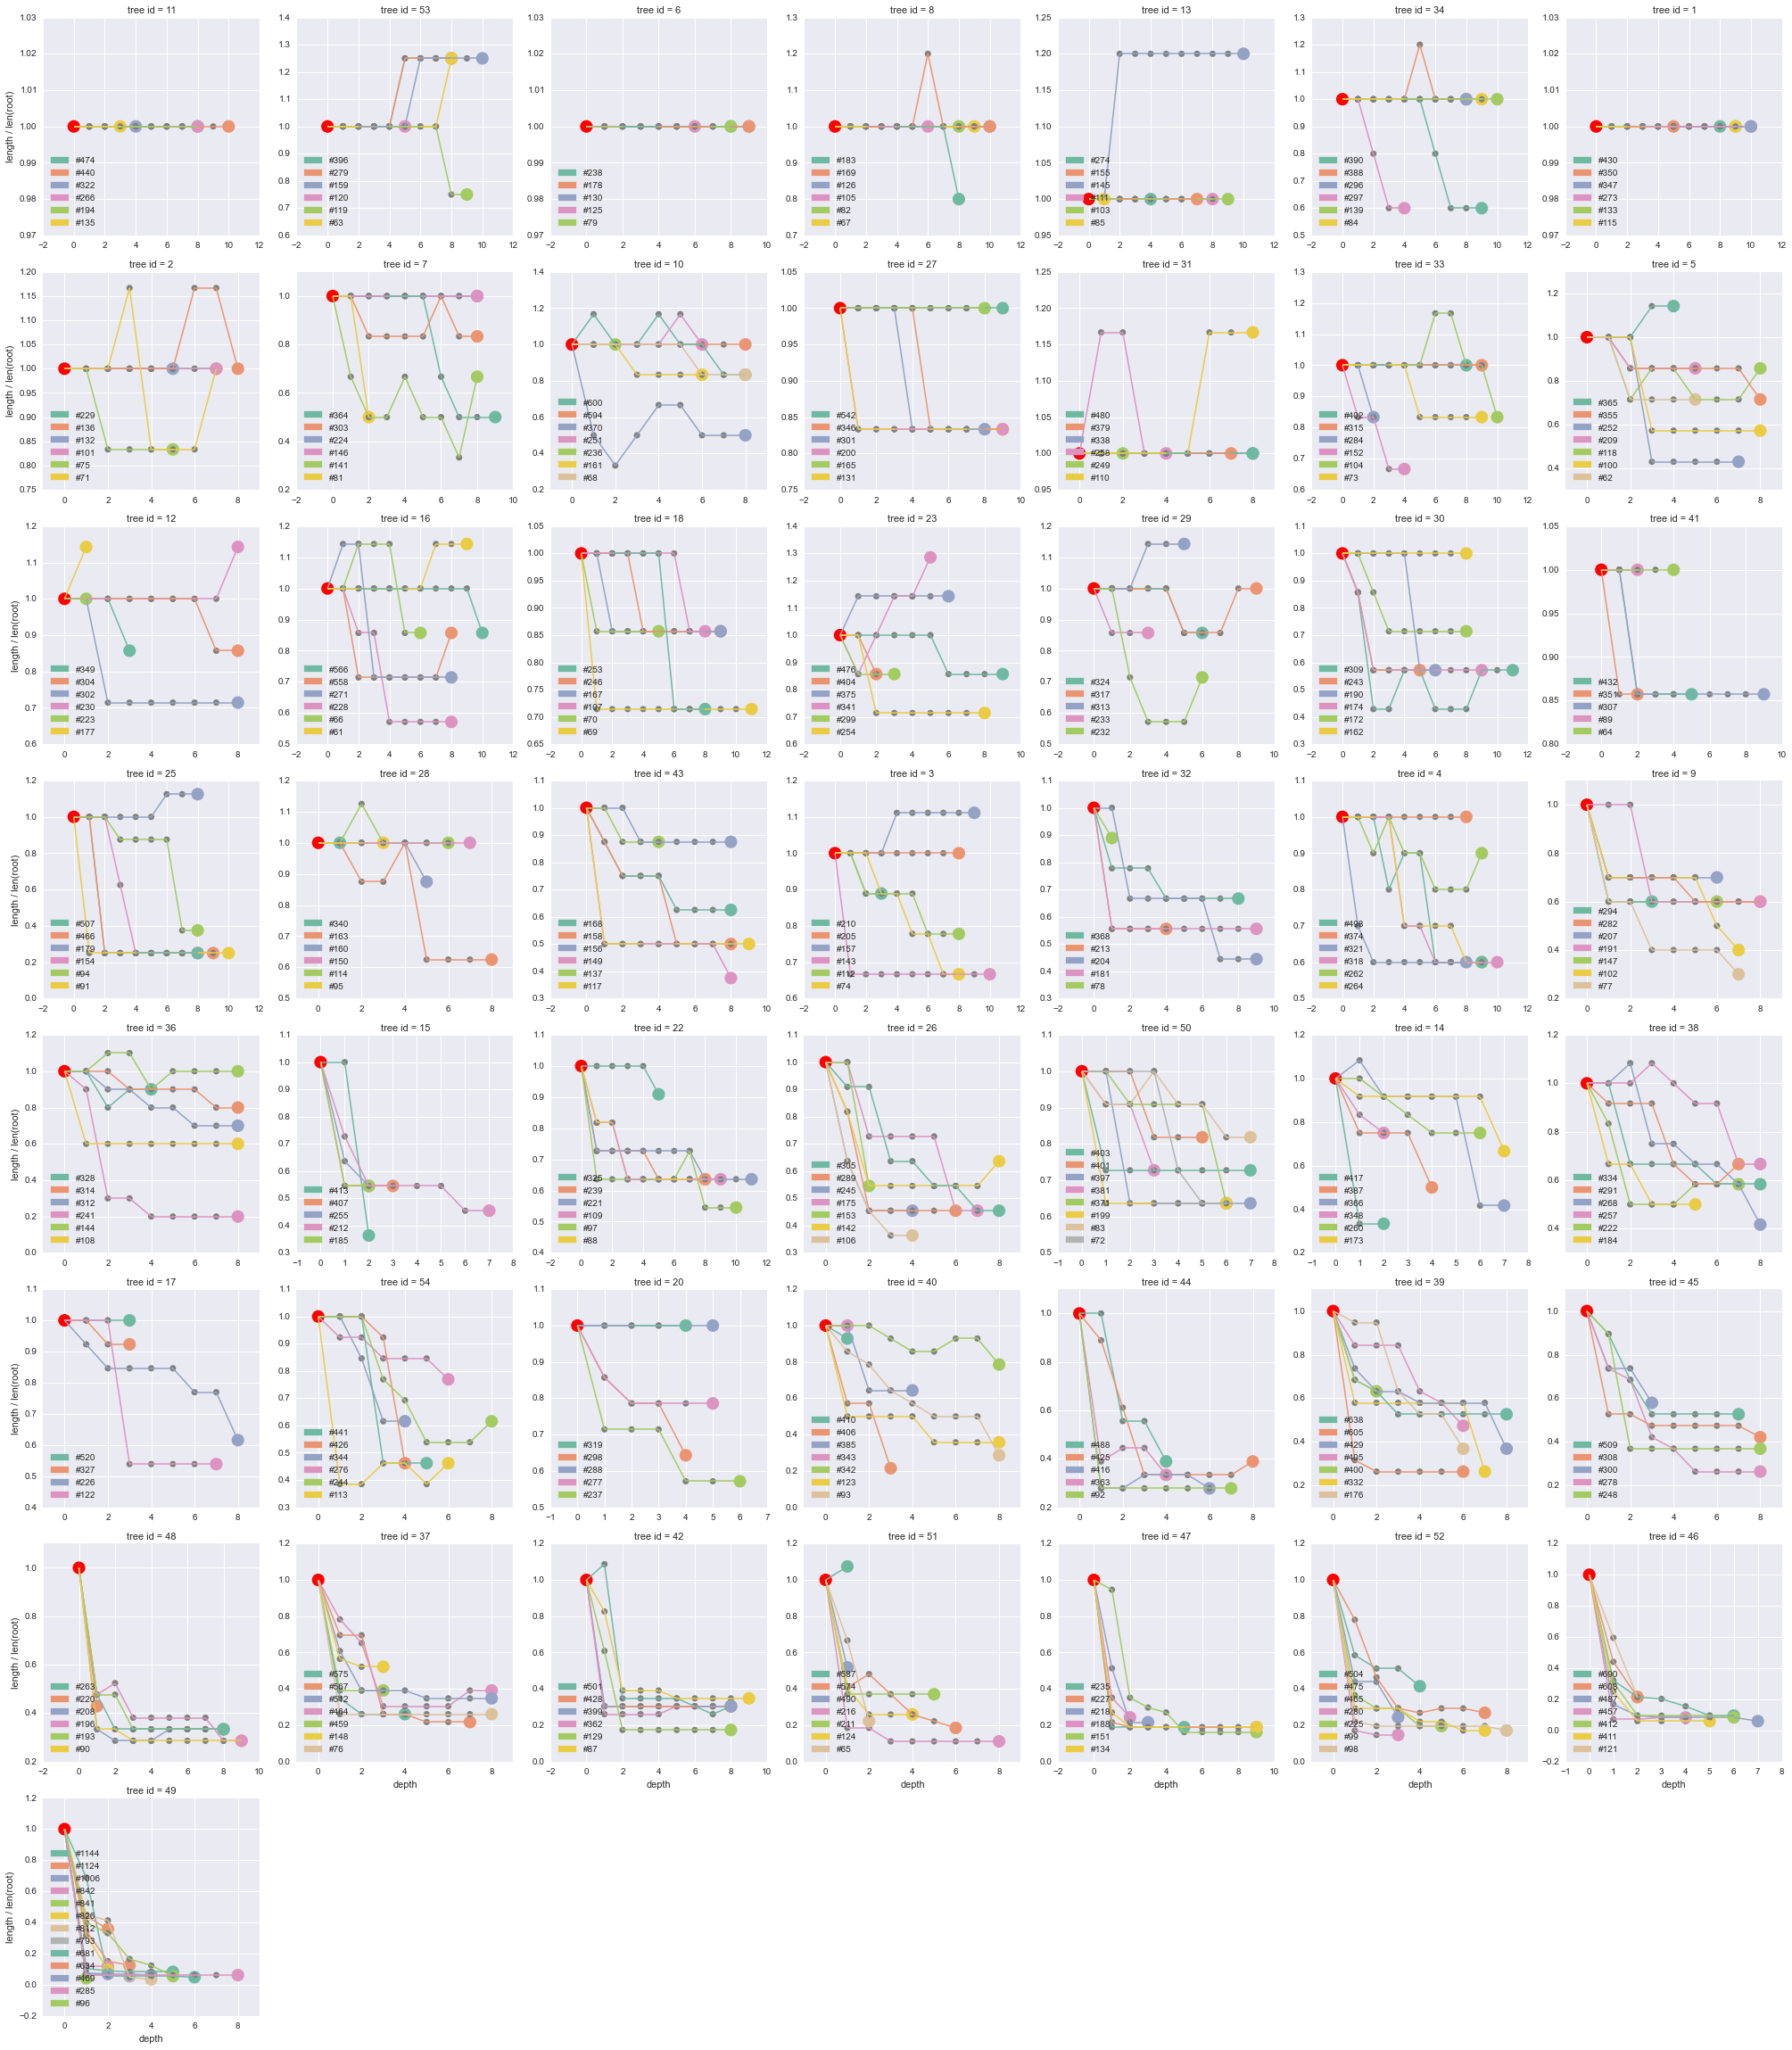

In [13]:
legends = {}
g = sb.FacetGrid(data, col='tree id', dropna=False,
                 sharex=False, sharey=False,
                 col_wrap=7, size=4, col_order=root_order['tree id'])
g.map_dataframe(plot_trajectories, 'depth', 'length / len(root)',
                set_chrome=True, legends=legends)
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[root_order['tree id'].iloc[i]], loc='lower left')
g.savefig('/home/sl/Downloads/gistr/trajectories_length-depth.png', dpi=300)